In [1]:
%matplotlib inline
import os
seed = 50
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
# from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
import random
from qpfs import *
from Autoencoder import *
from utils import *
from hankelization import * 
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
#device='cuda:0'
device='cpu'

# Neurotycho food-tracking dataset, 64 channels

The monkey was tracking food rewards with the hand contralateral to the implant side. ECoG data and motion data were recorded simultaneously during the task (details in the reference). There was no eye tracking. ECoG and motion data were sampled at 1KHz and 120Hz, respectively, with time stamps synchronized. ECoG data consists of $64-$ time series (channels). The original signals are converted into a space time representation using a wavelet transform with Morlet wavelet. So, $X \in \mathbb{R}^{T \times 64 \times 27}$, where 27 - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ - coordinates of hand position.

<img src="pictures/2023-04-14_03-18-41.png" alt="Drawing" style="width: 300px;"/>

<img src="pictures/2023-04-14_03-19-23.png" alt="Drawing" style="width: 300px;"/>

In [16]:
X_full = scipy.io.loadmat('X_ECoG64.mat')['features1']
Y_full = scipy.io.loadmat('Y_ECoG64.mat')['motion_dim1']
print('X:',X_full.shape[0])
print('Y:',Y_full.shape[0])

X: 18901
Y: 18901


In [ ]:
X_train_arr_n = []
X_test_arr_n = []
Y_train_arr_n = []
Y_test_arr_n = []
for j in range(10):
    X_test = np.transpose(X_full, (0,2,1))[(j*500)+3000:(j*500)+4500]
    Y_test = Y_full[(j*500)+3000:(j*500)+4500]
    X_train = np.transpose(X_full, (0,2,1))[(j*500):(j*500)+3000]
    Y_train = Y_full[(j*500):(j*500)+3000]

    X_test = (X_test - X_test.mean()) / X_test.std() 
    Y_test = (Y_test - Y_test.mean()) / Y_test.std()
    X_train = (X_train - X_train.mean()) / X_train.std()
    Y_train = (Y_train - Y_train.mean()) / Y_train.std()
    X_test_arr_n.append(X_test)
    Y_test_arr_n.append(Y_test)
    X_train_arr_n.append(X_train)
    Y_train_arr_n.append(Y_train)
    
X_train_arr_t = []
X_test_arr_t = []
Y_train_arr_t = []
Y_test_arr_t = []
for j in range(10):
    X_test_arr_t.append(torch.from_numpy(X_test_arr_n[j]).float().to(device))
    Y_test_arr_t.append(torch.from_numpy(Y_test_arr_n[j]).float().to(device))
    X_train_arr_t.append(torch.from_numpy(X_train_arr_n[j]).float().to(device))                    
    Y_train_arr_t.append(torch.from_numpy(Y_train_arr_n[j]).float().to(device))                                       

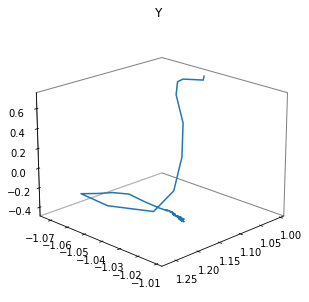

In [11]:
plot_y3D(Y_train_arr_n[0])

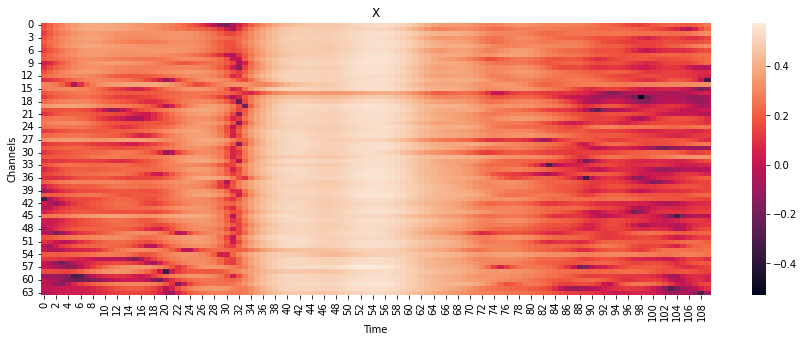

In [13]:
plot_x(X_train_arr_n[0])

## Without hankelization
### HOPLS

In [14]:
MSE_test = dict(np.load('experiments/ECoG64_wt_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (1,1), Km = 1, R = 24 nRMSE = 1.883698703273627


100%|██████████| 15/15 [05:50<00:00, 23.37s/it]


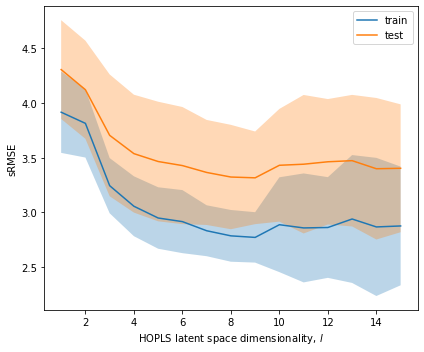

9 components with nRMSE = 3.316408683841935 +- 0.4235082701502681


In [4]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [1,1], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [5]:
U_x = scipy.io.loadmat('MPCA/64_X.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 27]


In [13]:
MSE_test = dict(np.load('experiments/ECoG64_wt_wt_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 1) nRMSE = 3.7697105753521183


In [6]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [1,1], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]

4.2407781833332825 +- 0.5063895056520623


### Autoencoder

In [42]:
MSE_test = dict(np.load('experiments/ECoG64_wt.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 8,10


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

RMSE_AE = []
for j in tqdm(range(10)):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks = [fr,32,16,8]
    model = AutoEncoder_tensor(3, [ks], [ch,10], y_sh, indexing=False).to(device)
    model = train(model, X_train_arr_t[j], Y_train_arr_t[j], X_test_arr_t[j], Y_test_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_train_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_test_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,2):   
        for rank2 in range(1,X_train_lower.shape[2]+1,2):
            try:
                RMSE_dict[f'{rank1},{rank2}'] = tensor_regression(X_train_lower, Y_train_arr_n[j], X_test_lower, Y_test_arr_n[j], [rank1,rank2])
            except:
                continue
    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [21]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

0.9559353622777211 +- 0.04136362105295119


In [46]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks = [fr,32,16,8]
model = AutoEncoder_tensor(3, [ks], [ch,10], y_sh, indexing=False).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 26140


## With hankelization along time dim

In [22]:
X_tr_ht_arr_n = []
X_te_ht_arr_n = []
Y_tr_ht_arr_n = []
Y_te_ht_arr_n = []
H_t_arr = []
for j in tqdm(range(10)):
    data, H_t = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10],[10]], [[0],[0]])
    X_tr_ht_n, Y_tr_ht_n, X_te_ht_n, Y_te_ht_n = data
    X_tr_ht_arr_n.append(X_tr_ht_n)
    Y_tr_ht_arr_n.append(Y_tr_ht_n)
    X_te_ht_arr_n.append(X_te_ht_n)
    Y_te_ht_arr_n.append(Y_te_ht_n)
    H_t_arr.append(H_t)
    
X_tr_ht_arr_t = []
X_te_ht_arr_t = []
Y_tr_ht_arr_t = []
Y_te_ht_arr_t = []
for j in range(10):
    X_tr_ht_arr_t.append(torch.from_numpy(X_tr_ht_arr_n[j]).float().to(device))
    X_te_ht_arr_t.append(torch.from_numpy(X_te_ht_arr_n[j]).float().to(device))
    Y_tr_ht_arr_t.append(torch.from_numpy(Y_tr_ht_arr_n[j]).float().to(device))                    
    Y_te_ht_arr_t.append(torch.from_numpy(Y_te_ht_arr_n[j]).float().to(device))  

100%|██████████| 10/10 [34:26<00:00, 206.62s/it]


### HOPLS

In [6]:
MSE_test = dict(np.load('experiments/ECoG64_ht_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,3,1), Km = (1,1), R = 19 nRMSE = 1.4879535936513941


100%|██████████| 15/15 [1:36:19<00:00, 385.29s/it]


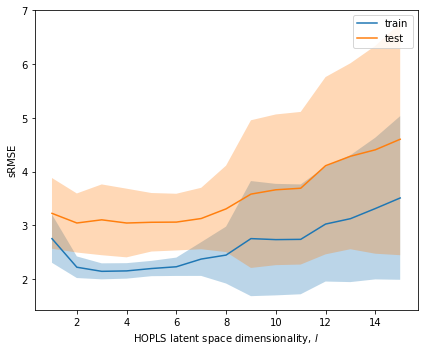

4 components with nRMSE = 3.0439172711699793 +- 0.5277136153409503


In [8]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [2,3,1], [1,1], hankelization=[H_t_arr[j][-2],H_t_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [9]:
U_x = scipy.io.loadmat('MPCA/64_X_ht.mat')['ans']
U_y = scipy.io.loadmat('MPCA/64_Y_ht.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 26]
Y [4, 3]


In [14]:
MSE_test = dict(np.load('experiments/ECoG64_ht_ht_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (1, 1, 1) nRMSE = 3.7223090389113107


In [10]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [1,1,1], U_x, U_y, H_t_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [04:56<00:00, 29.64s/it]

4.173437202723333 +- 0.4867131799998868


### Autoencoder

In [41]:
MSE_test = dict(np.load('experiments/ECoG64_ht.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 3,3,2


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,3]
    ks2 = [ch,16,8,2]

    model = AutoEncoder_tensor(4, [ks1, ks2], [10,3], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_ht_arr_t[j],Y_tr_ht_arr_t[j],X_te_ht_arr_t[j],Y_te_ht_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_ht_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_ht_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_ht_arr_n[j], X_test_lower, Y_te_ht_arr_n[j], [rank1,rank2,rank3], H_t_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [24]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.1667014877583912 +- 0.08373461416826895


In [45]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,3]
ks2 = [ch,16,8,2]

model = AutoEncoder_tensor(4, [ks1, ks2], [10,3], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 7510


## With hankelization along space dim

In [25]:
X_tr_hs_arr_n = []
X_te_hs_arr_n = []
Y_tr_hs_arr_n = []
Y_te_hs_arr_n = []
for j in tqdm(range(10)):
    data, H_s = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[2],[]], [[2],[]])
    X_tr_hs_n, Y_tr_hs_n, X_te_hs_n, Y_te_hs_n = data
    X_tr_hs_arr_n.append(X_tr_hs_n)
    Y_tr_hs_arr_n.append(Y_tr_hs_n)
    X_te_hs_arr_n.append(X_te_hs_n)
    Y_te_hs_arr_n.append(Y_te_hs_n)
    
X_tr_hs_arr_t = []
X_te_hs_arr_t = []
Y_tr_hs_arr_t = []
Y_te_hs_arr_t = []
for j in range(10):
    X_tr_hs_arr_t.append(torch.from_numpy(X_tr_hs_arr_n[j]).float().to(device))
    X_te_hs_arr_t.append(torch.from_numpy(X_te_hs_arr_n[j]).float().to(device))
    Y_tr_hs_arr_t.append(torch.from_numpy(Y_tr_hs_arr_n[j]).float().to(device))                    
    Y_te_hs_arr_t.append(torch.from_numpy(Y_te_hs_arr_n[j]).float().to(device))  

print('X train:', X_tr_hs_arr_n[0].shape)
print('Y train:', Y_tr_hs_arr_n[0].shape)
print('X test:', X_te_hs_arr_n[0].shape)
print('Y test:', Y_te_hs_arr_n[0].shape)

100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


X train: (3000, 27, 63, 2)
Y train: (3000, 3)
X test: (1500, 27, 63, 2)
Y test: (1500, 3)


### HOPLS

In [7]:
MSE_test = dict(np.load('experiments/ECoG64_hs_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,1,2), Km = (1), R = 15 nRMSE = 2.1363975215455926


100%|██████████| 15/15 [22:08<00:00, 88.59s/it] 


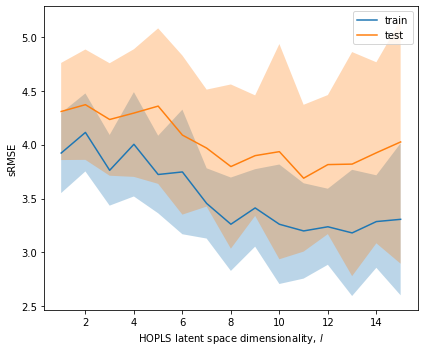

11 components with nRMSE = 3.6887036038776544 +- 0.45100281302674294


In [12]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [2,1,2], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [13]:
U_x = scipy.io.loadmat('MPCA/64_X_hs.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 22, 2]


In [15]:
MSE_test = dict(np.load('experiments/ECoG64_hs_hs_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 13, 2) nRMSE = 3.5777959658071623


In [14]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [1,13,2], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [23:59<00:00, 143.91s/it]

4.067204954602629 +- 0.47434322429713827


### Autoencoder

In [38]:
MSE_test = dict(np.load('experiments/ECoG64_hs.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 8,2,1


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 45
step_size = 100
X_tr_hs_n, X_te_hs_n = X_tr_hs_n.transpose(0,2,1,3), X_te_hs_n.transpose(0,2,1,3)

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8]

    model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,2], y_sh, indexing=True).to(device)
    model = train(model, X_tr_hs_arr_t[j].permute((0,2,1,3)),Y_tr_hs_arr_t[j],X_te_hs_arr_t[j].permute((0,2,1,3)),Y_te_hs_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_hs_arr_n[j], X_test_lower, Y_te_hs_arr_n[j], [rank1,rank2,rank3])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [27]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std()) #65

1.003498895584205 +- 0.04891091888120636


In [44]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8]

model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,2], y_sh, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 20917


## With hankelization along both dim

In [28]:
X_tr_hb_arr_n = []
X_te_hb_arr_n = []
Y_tr_hb_arr_n = []
Y_te_hb_arr_n = []
H_b_arr = []
for j in tqdm(range(10)):
    data, H_b = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10,2],[10]], [[0,2],[0]])
    X_tr_hb_n, Y_tr_hb_n, X_te_hb_n, Y_te_hb_n = data
    X_tr_hb_arr_n.append(X_tr_hb_n)
    Y_tr_hb_arr_n.append(Y_tr_hb_n)
    X_te_hb_arr_n.append(X_te_hb_n)
    Y_te_hb_arr_n.append(Y_te_hb_n)
    H_b_arr.append(H_b)
    
X_tr_hb_arr_t = []
X_te_hb_arr_t = []
Y_tr_hb_arr_t = []
Y_te_hb_arr_t = []
for j in range(10):
    X_tr_hb_arr_t.append(torch.from_numpy(X_tr_hb_arr_n[j]).float().to(device))
    X_te_hb_arr_t.append(torch.from_numpy(X_te_hb_arr_n[j]).float().to(device))
    Y_tr_hb_arr_t.append(torch.from_numpy(Y_tr_hb_arr_n[j]).float().to(device))                    
    Y_te_hb_arr_t.append(torch.from_numpy(Y_te_hb_arr_n[j]).float().to(device))  

print('X train:', X_tr_hb_arr_n[0].shape)
print('Y train:', Y_tr_hb_arr_n[0].shape)
print('X test:', X_te_hb_arr_n[0].shape)
print('Y test:', Y_te_hb_arr_n[0].shape)

100%|██████████| 10/10 [23:21<00:00, 140.14s/it]


X train: (2991, 10, 27, 63, 2)
Y train: (2991, 10, 3)
X test: (1491, 10, 27, 63, 2)
Y test: (1491, 10, 3)


### HOPLS

In [8]:
MSE_test = dict(np.load('experiments/ECoG64_hb_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (1,2,2,2), Km = (1,2), R = 14 nRMSE = 1.3975439967226706


100%|██████████| 13/13 [2:21:30<00:00, 653.08s/it]


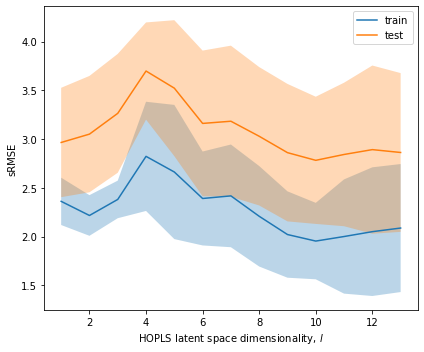

10 components with nRMSE = 2.7823106580078223 +- 0.4985923277140633


In [16]:
rmse = []
for R in tqdm(range(1,14)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], (1,2,2,2), (1,2), hankelization=[H_b_arr[j][-2],H_b_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [17]:
U_x = scipy.io.loadmat('MPCA/64_X_hb.mat')['ans']
U_y = scipy.io.loadmat('MPCA/64_Y_hb.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 21, 2]
Y [4, 3]


In [24]:
MSE_test = dict(np.load('experiments/ECoG64_hb_hb_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 1, 13, 2) nRMSE = 3.62506875732014


In [18]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], [1,1,13,2], U_x, U_y, H_b_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [1:32:35<00:00, 555.59s/it]  

4.037913299593528 +- 0.4388319317991596


### Autoencoder

In [37]:
MSE_test = dict(np.load('experiments/ECoG64_hb.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 3,3,3,1


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 35
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,3]
    ks2 = [ch-1,16,8,3]

    model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,1]], [10,3], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_hb_arr_t[j],Y_tr_hb_arr_t[j],X_te_hb_arr_t[j],Y_te_hb_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_hb_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hb_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                for rank4 in range(1,X_train_lower.shape[4]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3},{rank4}'] = tensor_regression(X_train_lower, Y_tr_hb_arr_n[j], X_test_lower, Y_te_hb_arr_n[j], [rank1,rank2,rank3,rank4], H_b_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [36]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.1788197626157413 +- 0.1417280104554335


In [43]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,3]
ks2 = [ch-1,16,8,3]

model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,1]], [10,3], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 7809


In [19]:
Y_random = []
Y_zeros = []
for j in range(10):
    Y_zeros.append(np.zeros(Y_test_arr_n[j].shape))
    Y_random.append(np.random.normal(0,1,Y_test_arr_n[j].shape))

In [20]:
rmse_random = []
rmse_zeros = []
for j in range(10):
    rmse_random.append(metric_nmse_(Y_random[j],Y_test_arr_n[j]))
    rmse_zeros.append(metric_nmse_(Y_zeros[j],Y_test_arr_n[j]))

In [21]:
print(np.array(rmse_zeros).mean(), '+-', np.array(rmse_zeros).std())
print(np.array(rmse_random).mean(), '+-', np.array(rmse_random).std())

4.474207502687912 +- 0.491129890947943
6.136094229579739 +- 0.5897751171552376


In [2]:
plt.rcParams.update({
    # Use LaTeX default serif font-family.
    # https://matplotlib.org/stable/tutorials/text/usetex.html#sphx-glr-tutorials-text-usetex-py
     "font.family": "serif",
     # Use specific cursive fonts.
     "font.cursive": ["Comic Neue", "Comic Sans MS"],
 })
plt.style.use('seaborn-white')

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 20
%matplotlib inline
%config InlineBackend.figure_format='retina'

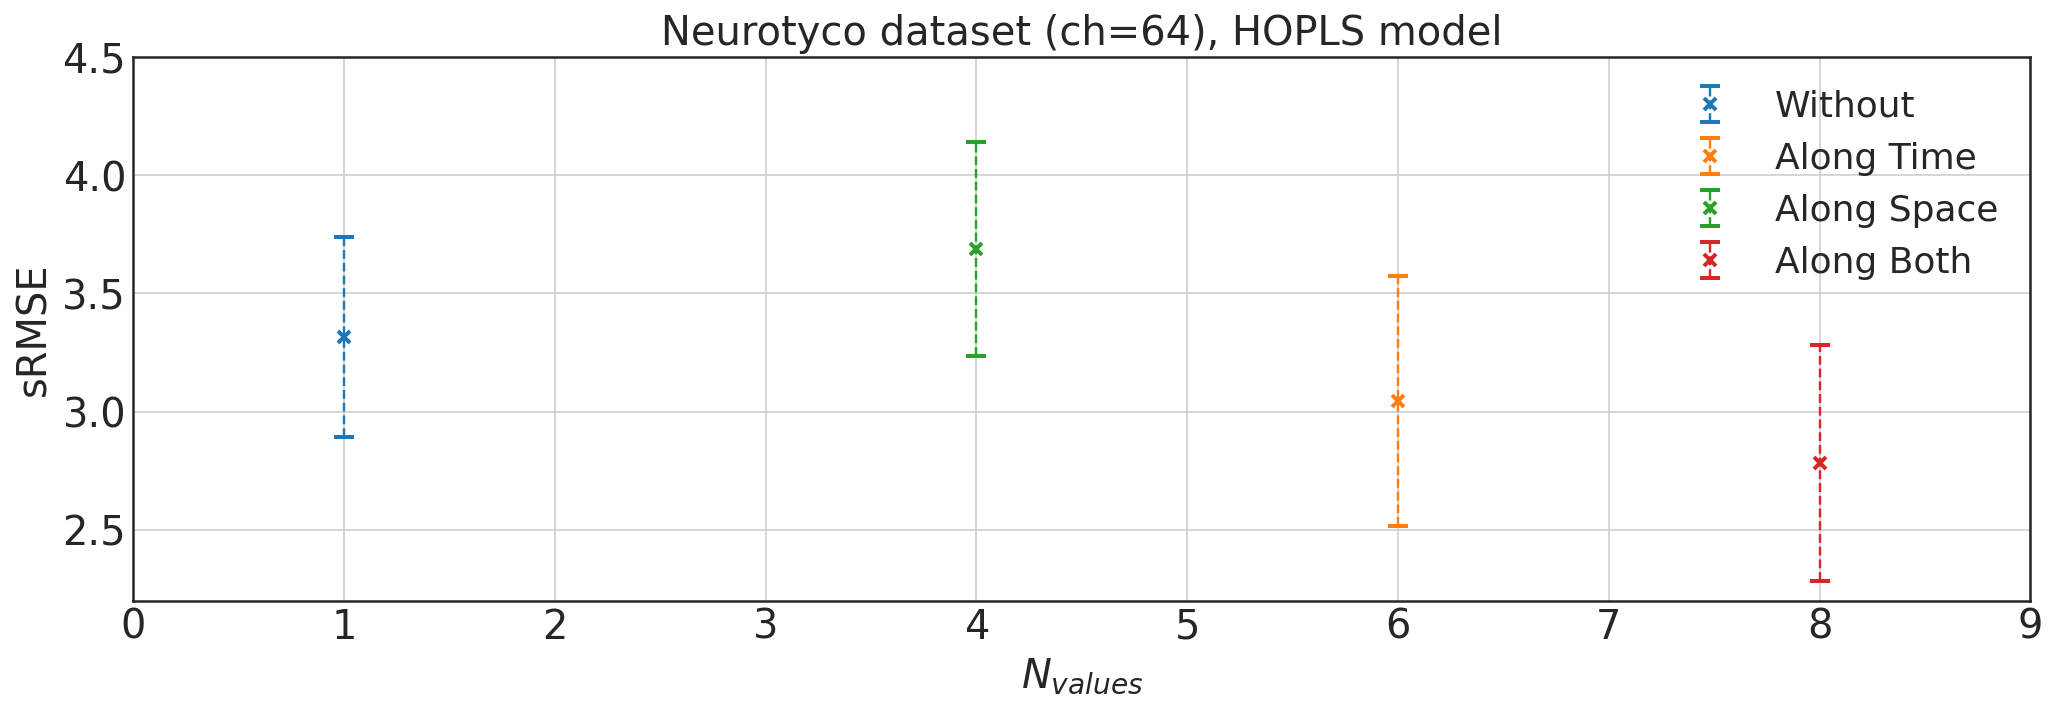

In [31]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([1, 6, 4, 8])
ys = np.array([3.316, 3.044, 3.688, 2.782])
es = np.array([0.424, 0.528, 0.451, 0.499])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*35,5),ha="center")
plt.ylim(2.2,4.5)
plt.xlim(0,9)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG64_HOPLS.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=64), HOPLS model')
plt.show()

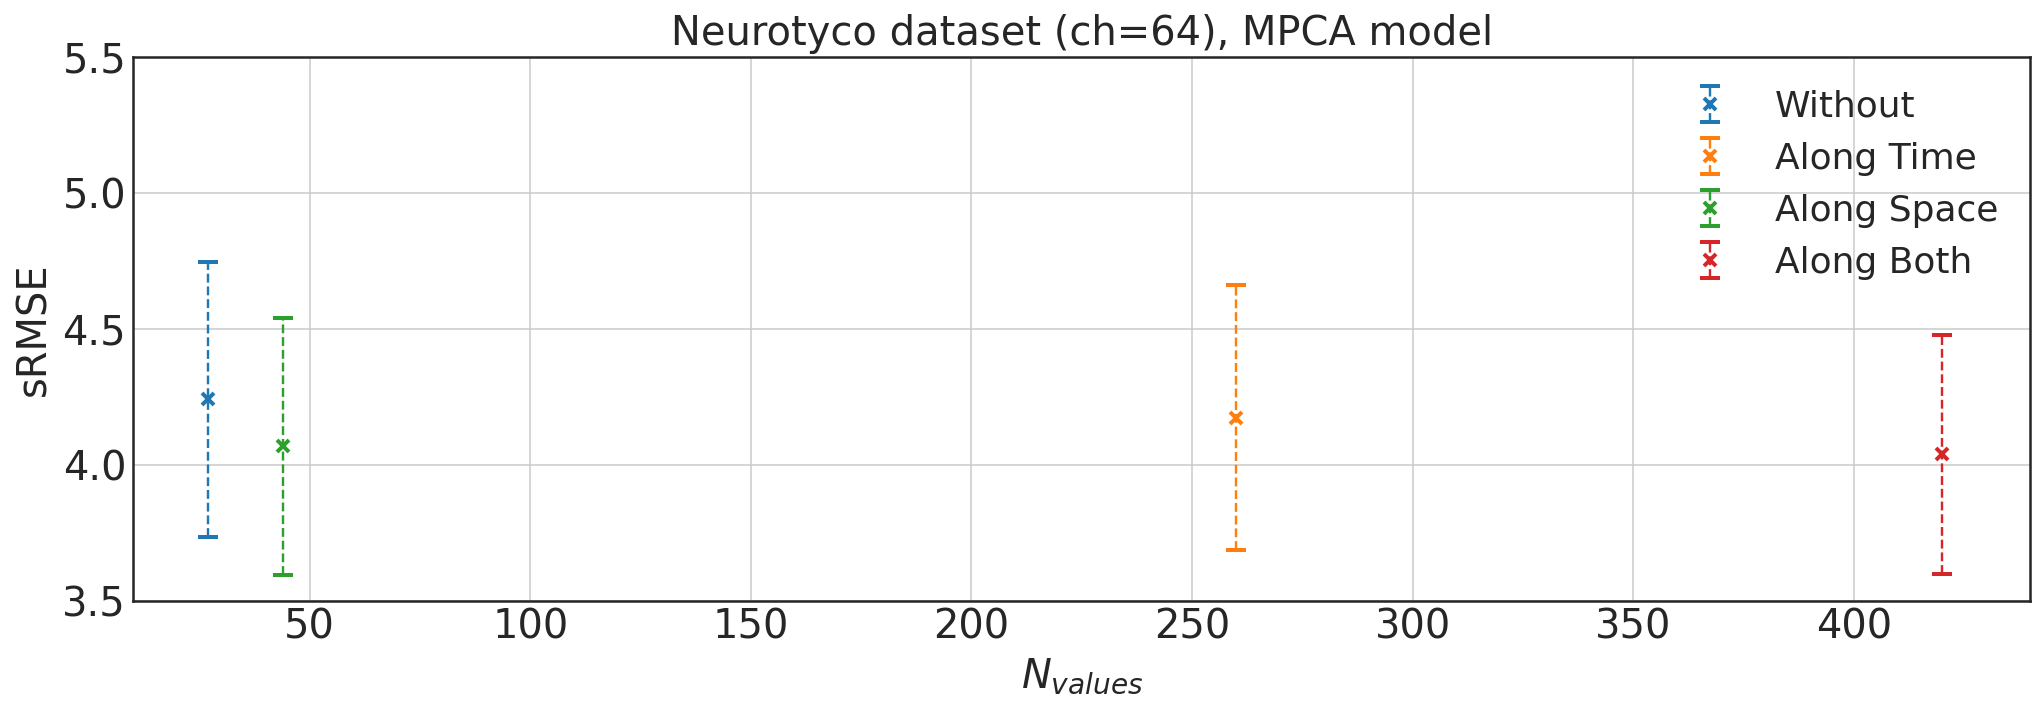

In [34]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([27, 260, 44, 420])
ys = np.array([4.241, 4.173, 4.067, 4.038])
es = np.array([0.506, 0.487, 0.474, 0.439])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*35,5),ha="center")
plt.ylim(3.5,5.5)
plt.xlim(10,440)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG64_MPCA.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=64), MPCA model')
plt.show()
plt.show()

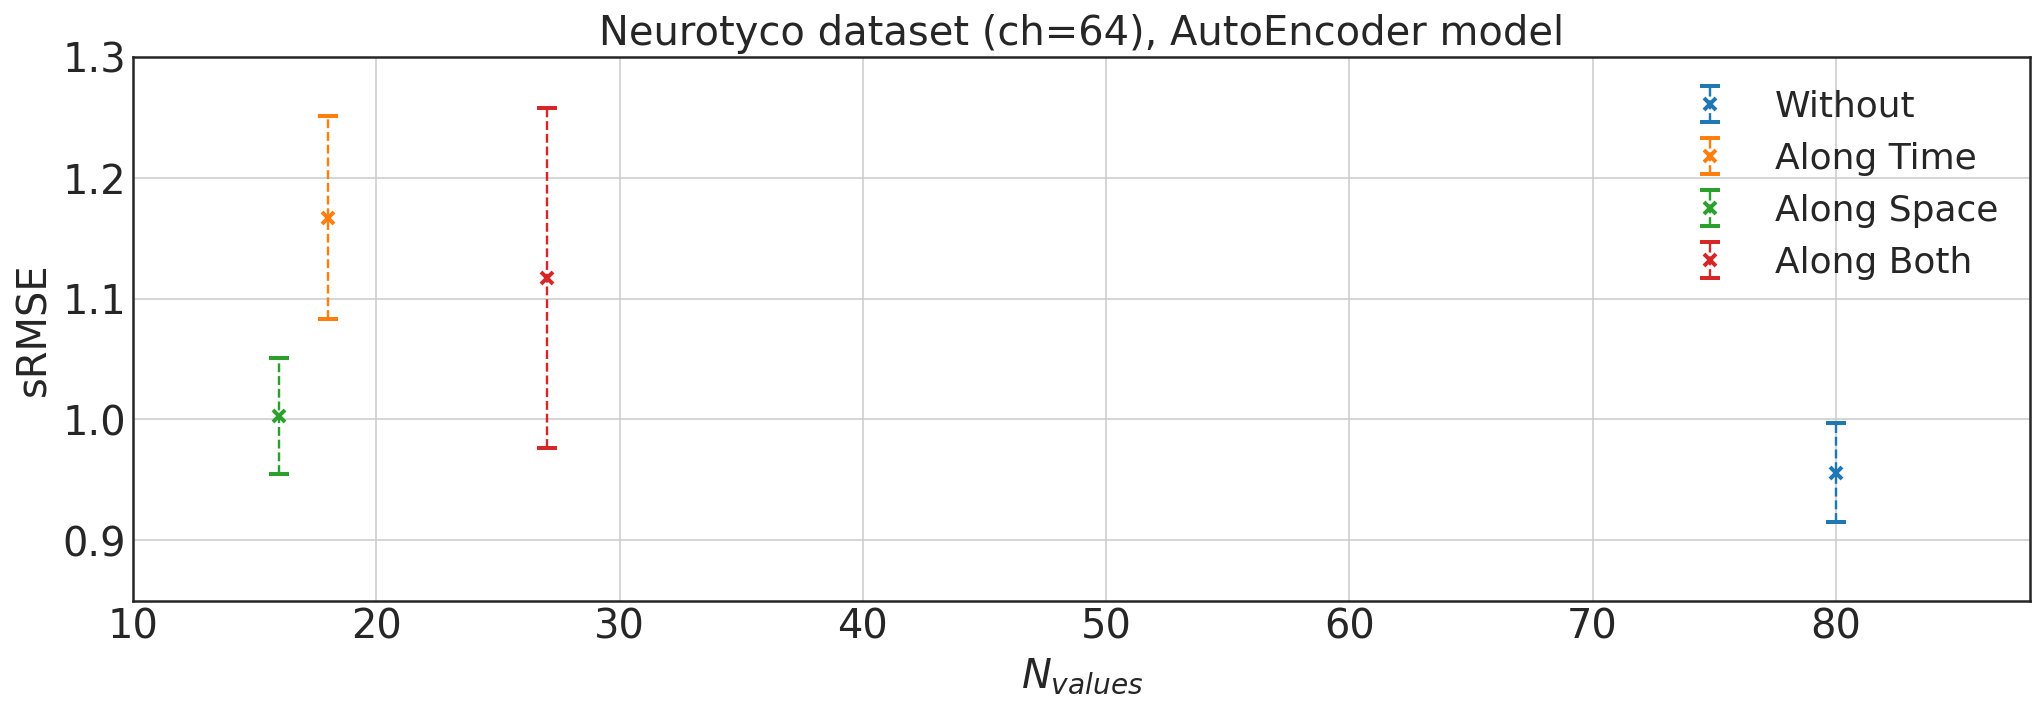

In [4]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([80, 18, 16, 27])
ys = np.array([0.956, 1.167, 1.003, 1.117])
es = np.array([0.041, 0.084, 0.048, 0.141])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*35,5),ha="center")
plt.ylim(0.85,1.3)
plt.xlim(10,88)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG64_AE.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=64), AutoEncoder model')
plt.show()
plt.show()